In [1]:
import itertools
import os
import subprocess

from collections import Counter

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import seaborn as sns
import requests
from scipy import stats

import torch

# set resolution of plt figures to 120
plt.rcParams['figure.dpi'] = 150
# Helvetica doesn't support up arrow unicode
#plt.rcParams['font.family'] = 'Helvetica'

from netam.framework import load_crepe
from netam import dnsm
from netam.sequences import translate_sequence, translate_sequences
from netam.common import pick_device, heavy_chain_shim
from dnsmex.dxsm_performance import prep_compare_df, plot_performance_metrics
from dnsmex.dnsm_zoo import validation_burrito_of
from dnsmex.local import localify

device = pick_device()
if device.type == 'mps':
    print("Actually, using CPU")
    device = "cpu"

figures_dir = localify("FIGURES_DIR")

Using CPU


In [2]:
compare_df = prep_compare_df(
    "../../dnsm-train/_ignore/model_compare.csv", 
    localify("DATA_DIR/vX_summary.csv"), 
    "../output/dnsm_model_parameter_count.csv")

In [3]:
compare_df

,overlap,residual,total_obs,total_exp,model_nickname,test dataset,model,train dataset,pcps,samples,families,abbrv_param_count,head_count,d_model_per_head,layer_count,parameters
0,0.933961,0.015810,25856.0,26892.277791,dnsm_13k-v1jaffe+v1tang-joint,v1rodriguez_IGHV1,dnsm_13k,v1jaffe+v1tang,751369,25,98345,13K,4,4,3,13489
1,0.948746,0.013078,56619.0,58860.472163,dnsm_13k-v1jaffe+v1tang-joint,v1rodriguez_IGHV3,dnsm_13k,v1jaffe+v1tang,751369,25,98345,13K,4,4,3,13489
2,0.929402,0.017736,30146.0,31400.505947,dnsm_13k-v1jaffe+v1tang-joint,v1rodriguez_IGHV4,dnsm_13k,v1jaffe+v1tang,751369,25,98345,13K,4,4,3,13489
3,0.957773,0.012306,25856.0,26191.456461,dnsm_1m-v1jaffe+v1tang-joint,v1rodriguez_IGHV1,dnsm_1m,v1jaffe+v1tang,751369,25,98345,1.2M,8,16,5,1192577
4,0.967475,0.008209,56619.0,57111.124454,dnsm_1m-v1jaffe+v1tang-joint,v1rodriguez_IGHV3,dnsm_1m,v1jaffe+v1tang,751369,25,98345,1.2M,8,16,5,1192577
5,0.961259,0.009397,30146.0,30625.414522,dnsm_1m-v1jaffe+v1tang-joint,v1rodriguez_IGHV4,dnsm_1m,v1jaffe+v1tang,751369,25,98345,1.2M,8,16,5,1192577
6,0.958383,0.012184,25856.0,26351.729742,dnsm_4m-v1jaffe+v1tang-joint,v1rodriguez_IGHV1,dnsm_4m,v1jaffe+v1tang,751369,25,98345,4.7M,8,32,5,4744449
7,0.967560,0.008118,56619.0,57697.381111,dnsm_4m-v1jaffe+v1tang-joint,v1rodriguez_IGHV3,dnsm_4m,v1jaffe+v1tang,751369,25,98345,4.7M,8,32,5,4744449
8,0.960451,0.009637,30146.0,30904.021763,dnsm_4m-v1jaffe+v1tang-joint,v1rodriguez_IGHV4,dnsm_4m,v1jaffe+v1tang,751369,25,98345,4.7M,8,32,5,4744449
9,0.951833,0.012520,25856.0,26440.939457,dnsm_77k-v1jaffe+v1tang-joint,v1rodriguez_IGHV1,dnsm_77k,v1jaffe+v1tang,751369,25,98345,77K,4,8,5,76961


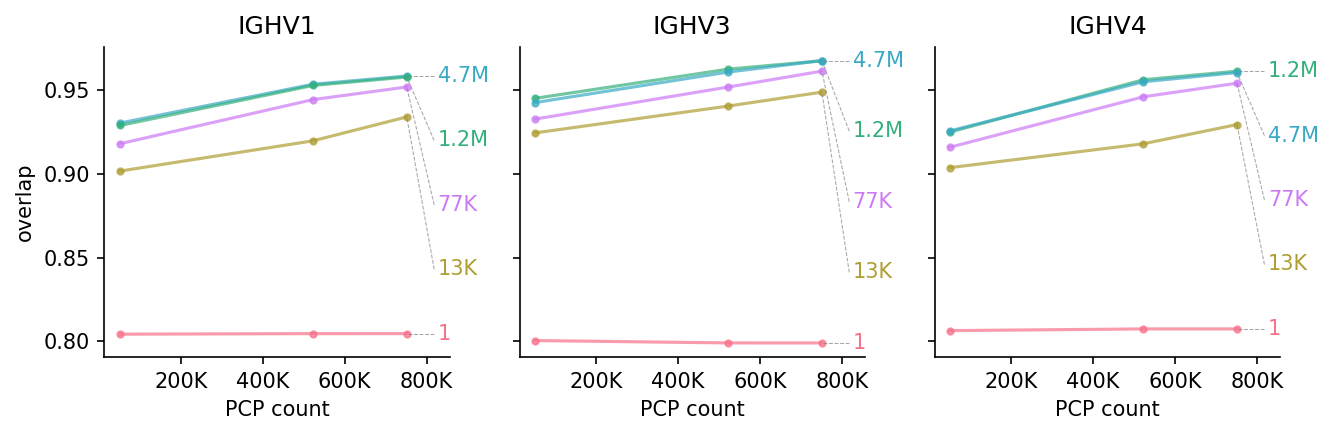

In [4]:
plot_performance_metrics(compare_df, ["overlap"], figures_dir + "dnsm_performance_by_size.svg")

In [5]:
crepe_df = compare_df.drop(columns=["overlap", "residual", "test dataset"])
crepe_df = crepe_df.drop_duplicates()
crepe_df = crepe_df[crepe_df["model"] != "single"]
crepe_df = crepe_df.sort_values(by=["pcps", "parameters"]).reset_index(drop=True)
crepe_df["crepe"] = crepe_df["model_nickname"].apply(lambda x: load_crepe(f"../../dnsm-train/trained_models/{x}"))

Index(['dnsm_13k', 'dnsm_77k', 'dnsm_1m', 'dnsm_4m'], dtype='object')


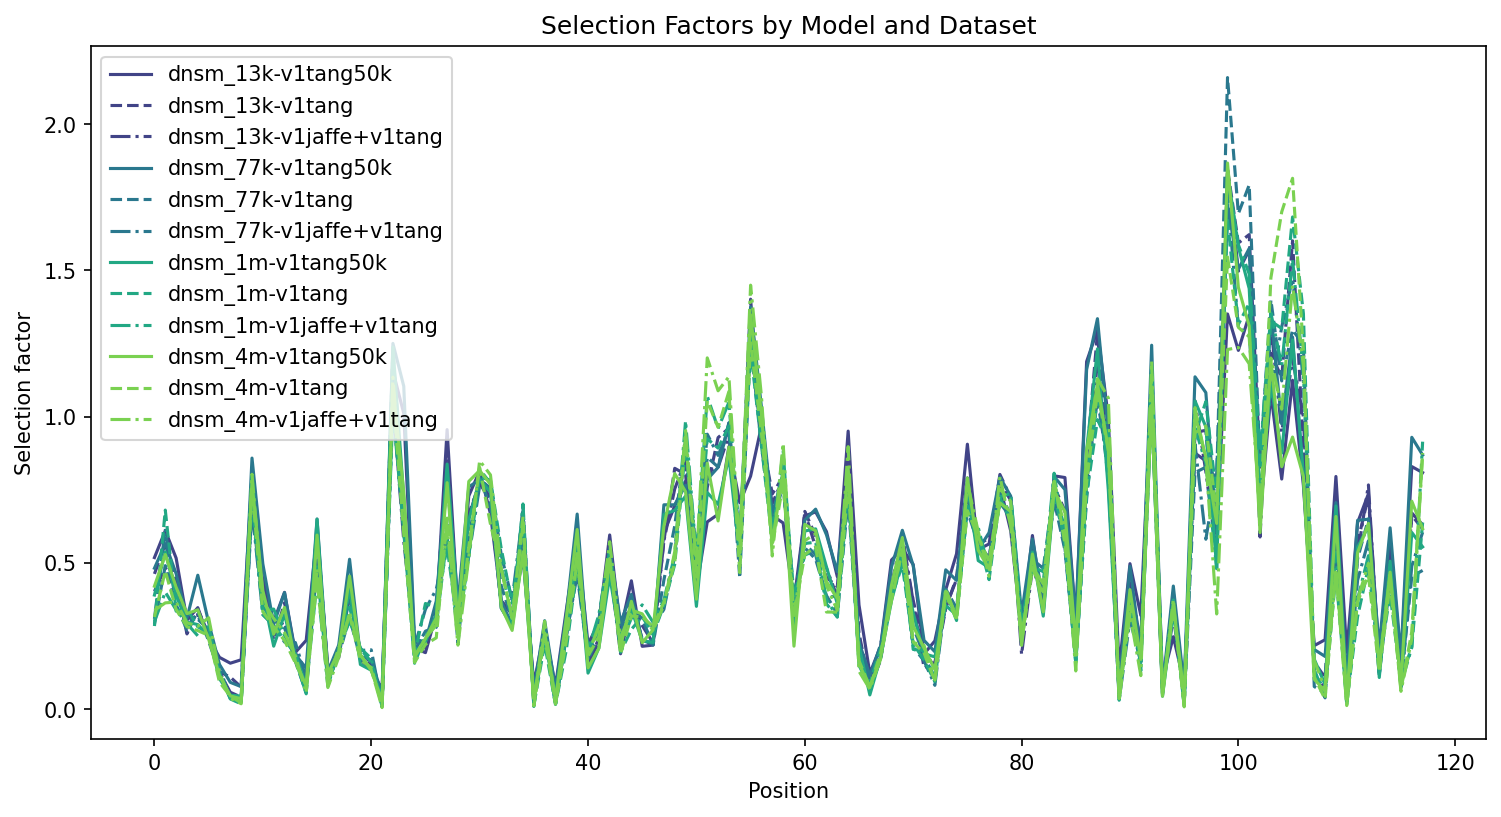

In [6]:
igh_6mtx_with_constant = "QVQLQESGPGLVKSSETLSLSCTVSGASISNFYWSWVRQPPGKGLEWMGSIYYTGTITYNPSLKSRLTMSVDTSKNQFSLKLNSVTAADTAVYSCAGLDRFNWNDEGDCWGQGTLVTVFSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDK"
igh_6mtx = igh_6mtx_with_constant[:118]

igh_2vxs_with_constant = "EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDLIHGVTRNWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPQPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDKTH"

igh_2vxs = igh_2vxs_with_constant[:118]


def make_selection_factors_df(seq):
    def selection_factors_of_crepe(crepe):
        return heavy_chain_shim(crepe)([seq])[0]
    
    df = pd.DataFrame({
        model_nickname: selection_factors_of_crepe(crepe)
        for model_nickname, crepe in zip(crepe_df["model_nickname"], crepe_df["crepe"])
    })

    transformed_data = []
    for column in df.columns:
        parts = column.split('-')
        model, dataset, _ = parts[0], parts[1], parts[2]
        for idx, value in enumerate(df[column]):
            transformed_data.append([idx, value, model, dataset])
    
    return pd.DataFrame(transformed_data, columns=['Position', 'Selection factor', 'Model', 'Dataset'])

def unique_preserving_order(series):
    return pd.Categorical(series, categories=series.unique(), ordered=True).categories

def plot_selection_factors(seq):
    df = make_selection_factors_df(seq)
    fig, ax = plt.subplots(figsize=(12, 6))

    # Define colors and line styles
    unique_models = unique_preserving_order(df['Model'])
    print(unique_models)
    unique_datasets = unique_preserving_order(df['Dataset'])
    palette = sns.color_palette("viridis", len(unique_models))
    line_styles = ['-', '--', '-.', ':']
    
    # Create a color and linestyle mapping
    color_mapping = {model: color for model, color in zip(unique_models, palette)}
    linestyle_mapping = {dataset: linestyle for dataset, linestyle in zip(unique_datasets, line_styles)}

    grouped = df.groupby(['Model', 'Dataset'])
    # Plot each line
    for (model, dataset) in itertools.product(unique_models, unique_datasets):
        group = grouped.get_group((model, dataset))
        ax.plot(group['Position'], group['Selection factor'], 
                label=f"{model}-{dataset}", 
                color=color_mapping[model], 
                linestyle=linestyle_mapping[dataset])
    
    ax.legend()
    ax.set_xlabel("Position")
    ax.set_ylabel("Selection factor")
    plt.title('Selection Factors by Model and Dataset')
    return fig

_ = plot_selection_factors(igh_2vxs)

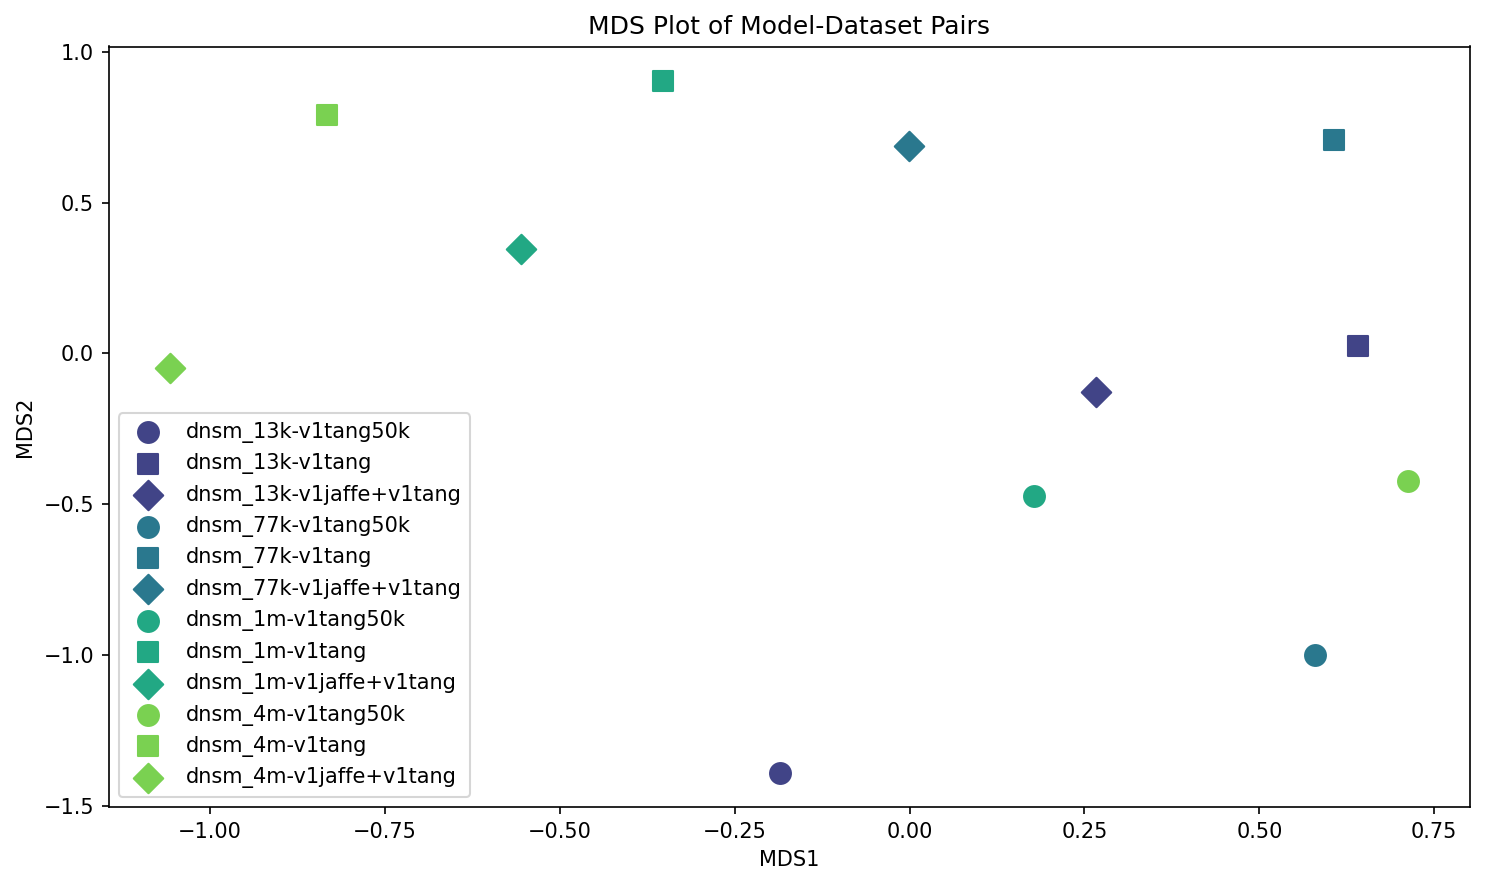

In [7]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

def mds_plot_of_selection_factors_df(df):

    # Pivot the data to have models-datasets as rows and positions as columns
    pivot_df = df.pivot_table(index=['Model', 'Dataset'], columns='Position', values='Selection factor')

    # Compute the Euclidean distance matrix
    dist_matrix = pairwise_distances(pivot_df, metric='euclidean')

    # Apply MDS to reduce to 2 dimensions
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    mds_coords = mds.fit_transform(dist_matrix)

    # Create a DataFrame for MDS results
    mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2'])
    mds_df['Model'] = pivot_df.index.get_level_values(0)
    mds_df['Dataset'] = pivot_df.index.get_level_values(1)

    # Define colors and markers
    unique_models = unique_preserving_order(df['Model'])
    unique_datasets = unique_preserving_order(df['Dataset'])
    palette = sns.color_palette("viridis", len(unique_models))
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']

    # Create a color and marker mapping
    color_mapping = {model: color for model, color in zip(unique_models, palette)}
    marker_mapping = {dataset: marker for dataset, marker in zip(unique_datasets, markers)}

    # Plot the MDS results
    fig, ax = plt.subplots(figsize=(10, 6))

    grouped = mds_df.groupby(['Model', 'Dataset'])
    for model, dataset in itertools.product(unique_models, unique_datasets):
        group = grouped.get_group((model, dataset))
        ax.scatter(group['MDS1'], group['MDS2'], 
                   label=f"{model}-{dataset}", 
                   color=color_mapping[model], 
                   marker=marker_mapping[dataset],
                   s=100)  # s is the marker size

    ax.legend()
    ax.set_xlabel('MDS1')
    ax.set_ylabel('MDS2')
    ax.set_title('MDS Plot of Model-Dataset Pairs')
    plt.tight_layout()

    return fig

df = make_selection_factors_df(igh_2vxs)
_ = mds_plot_of_selection_factors_df(df)

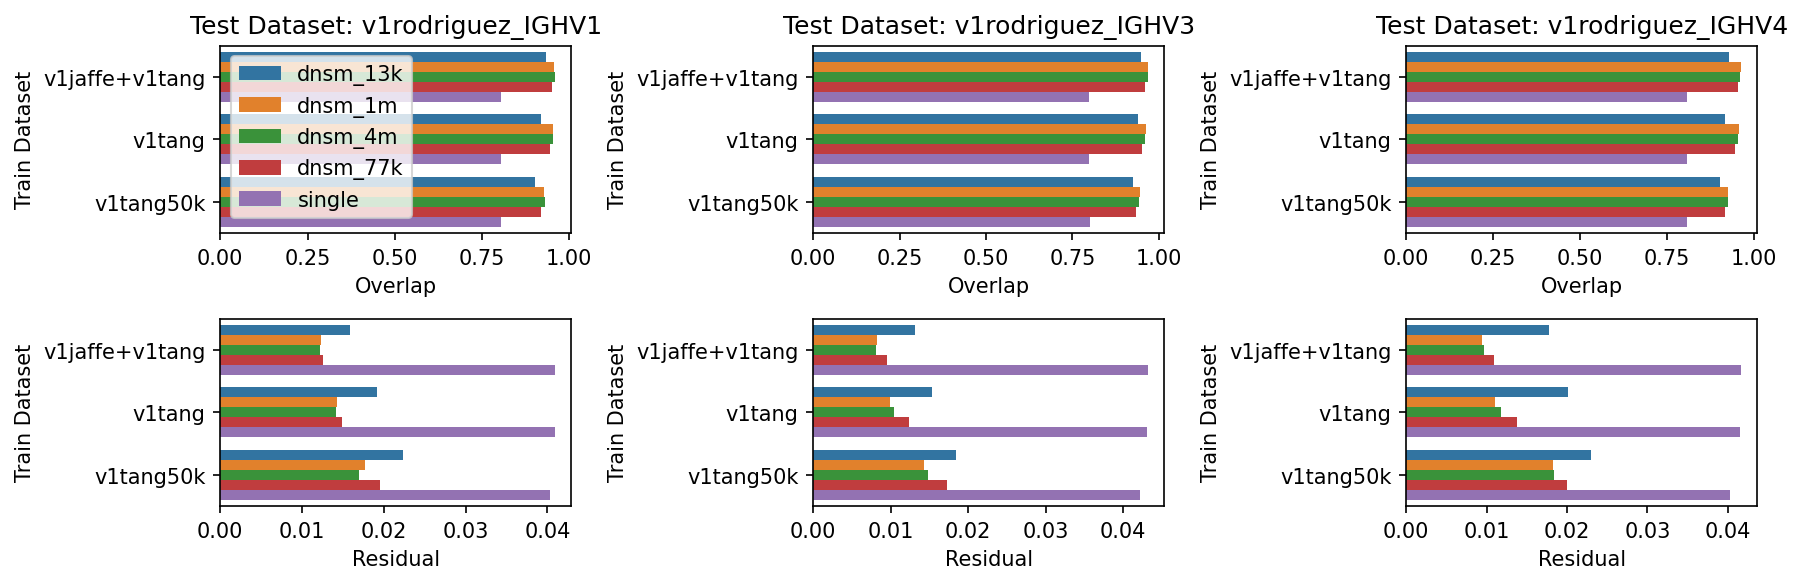

In [8]:
df = compare_df.copy()

# drop any row where model contains "single"
#df = df[~df['model'].str.contains('single')]

df = df.sort_values(by=['model']).reset_index(drop=True)

# Get the unique test datasets in the order they appear
test_datasets = df['test dataset'].unique()
metrics = ["overlap", "residual"]

# Create a figure with subplots
fig, axes = plt.subplots(len(metrics), len(test_datasets), figsize=(4 * len(test_datasets), 2*len(metrics)))

if len(test_datasets) == 1:
    axes = [axes]
if len(metrics) == 1:
    axes = [axes]

# Loop over each metric and each test dataset to create barplots
for i, metric in enumerate(metrics):
    for j, test_dataset in enumerate(test_datasets):
        ax = axes[i][j] if len(metrics) > 1 else axes[j]
        sns.barplot(
            data=df[df['test dataset'] == test_dataset],
            x=metric,
            y='train dataset',
            hue='model',
            ax=ax,
            #order=train_dataset_order,
        )
        ax.set_xlabel(metric.replace("_", " ").title())
        ax.set_ylabel('Train Dataset')
        if i == 0:
            ax.set_title(f'Test Dataset: {test_dataset}')
        xmin, xmax = ax.get_xlim()
        #ax.set_xlim(xmax * 0.85, xmax)
        #ax.tick_params(axis='x', rotation=-20)

        if i == 0 and j == 0:
            ax.legend(loc='upper left')
        else:
            ax.get_legend().remove()

        # draw a vertical line at the value of the metric for dnsm_1m trained on v1jaffe+v1tang
        #line_x_value = df[(df["model"] == "dnsm_1m") & (df["train dataset"] == "v1jaffe+v1tang") & (df["test dataset"] == test_dataset)][metric].values[0]
        #ax.axvline(x=line_x_value, color='gray', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


### Visualizations for individual sequences

In [9]:
class ResultContainer:
    def __init__(self, aa_seq, cdr_locations, selection_factors, name):
        self.aa_seq = aa_seq
        self.cdr_locations = cdr_locations
        self.cdr_colors = {
            cdr: color for cdr, color 
            in zip(['CDR1', 'CDR2', 'CDR3'], mcolors.XKCD_COLORS)}
        self.selection_factors = selection_factors
        self.name = name.lower()
        # self.plot_color = "#7570b3" # original Dark2
        self.plot_color = "#675ed6" # more visible
    
    def plot_selection_factors(self, plot_letters=True):
        plt.figure(figsize=(20, 6))
        # plt.rcParams.update({'font.size': 18})

        if plot_letters:
            for i, letter in enumerate(self.aa_seq, start=1):  # Start indexing from 1
                plt.scatter(i, self.selection_factors[i-1], color=self.plot_color, marker=f'${letter}$')
            # Alternating column background
            for i in range(1, len(self.selection_factors) + 1):
                if i % 2 == 1:
                    plt.axvspan(i-0.5, i+0.5, color='grey', alpha=0.1, lw=0)
        else:
            plt.plot(np.arange(1, len(self.selection_factors) + 1), self.selection_factors, label=self.name, color=self.plot_color, linestyle='-', alpha=0.95)

        # Highlighting CDR regions
        for cdr, location_range in self.cdr_locations.items():
            start, end = location_range
            start += 0.5
            end += 0.5
            plt.hlines(y=-0.03, xmin=start, xmax=end, colors=self.cdr_colors[cdr], linewidths=5, label=f'{cdr}')
            plt.text((start + end) / 2, -0.15, cdr, ha='center', color="dimgray", fontsize=20)

        plt.hlines(y=0.0, xmin=0, xmax=len(self.selection_factors) - 1, colors='grey', alpha=0.5)
        plt.hlines(y=1.0, xmin=0, xmax=len(self.selection_factors) - 1, linestyles='dashed', colors='grey', alpha=0.5)
        plt.xticks(np.arange(0, len(self.selection_factors) + 1, 10))
        plt.box(False)
        plt.xlabel('Site')
        plt.tight_layout()
        plt.gca().tick_params(axis='x', pad=15, length=0)
        plt.gca().tick_params(axis='y', pad=-60, length=0, labelsize=14)

        # plt.ylabel('Selection factor', labelpad=-5)
        plt.text(-9, 1.15, '⬆\nDiversifying\nSelection️', ha='center', va='bottom', fontsize=20)
        plt.text(-9, 1.035, 'Neutral', ha='center', va='top', fontsize=20)
        plt.text(-9, 0.80, 'Purifying\nSelection\n⬇', ha='center', va='top', fontsize=20)

        if not plot_letters:
            plt.gca().axes.get_xaxis().set_visible(False)

        file_suffix = '.letters' if plot_letters else '.line'
        plt.savefig(figures_dir + f'{self.name}-selection-factors{file_suffix}.svg', format='svg', dpi=1200, bbox_inches='tight')

    def write_dms_viz_jsons_complete(self, included_chains="H", excluded_chains="C D I J K L M N O"):
        site_count = self.write_dms_viz_input_csvs()
        self.write_dms_viz_sitemap(site_count)
        return self.run_configure_dms_viz(included_chains, excluded_chains)

    def run_configure_dms_viz(self, included_chains="H", excluded_chains="C D I J K L M N O"):
        print(f"Running configure-dms-viz for {self.name}...")
        # The following should work but somehow the colors are not applied correctly. So we go hardcoded in the next line.
        base_cmd = f"configure-dms-viz format --name {self.name} --structure {self.name} --colors \"{self.plot_color},#808080\" --included-chains \"{included_chains}\""
        # base_cmd = f"configure-dms-viz format --name {self.name} --structure {self.name} --colors \"#675ed6,#808080\" --included-chains \"{included_chains}\""
        if excluded_chains != "":
            base_cmd += f" --excluded-chains \"{excluded_chains}\""

        sitemap_file = f"output/for-dms-viz.{self.name}.sitemap.csv"
        output_files = [
            f"output/{self.name}-dnsm.json",
            f"output/{self.name}-asa.json",
            f"output/{self.name}-combined.json"
        ]
        metrics = ["DNSM", "rel_asa_authH", "factor"]
        inputs = [f"output/for-dms-viz.{self.name}.input.csv", f"output/for-dms-viz.{self.name}.input.csv", f"output/for-dms-viz.{self.name}.molten.csv"]
        conditions = ["", "", "--condition condition"]
        
        cmds = []
        for metric, input_file, condition in zip(metrics, inputs, conditions):
            cmd = f"{base_cmd} --input {input_file} --metric {metric} {condition} --sitemap {sitemap_file} --output {output_files[metrics.index(metric)]}"
            cmds.append(cmd)
        
        # Execute the shell commands
        for cmd in cmds:
            subprocess.run(cmd, shell=True, check=True)

        return cmds
    
    def write_dms_viz_input_csvs(self):
        viz_df = pd.DataFrame({"wildtype": list(self.aa_seq)})
        viz_df["site"] = viz_df.index + 1
        viz_df["mutant"] = '-'
        viz_df["DNSM"] = self.selection_factors
        asa_path = f"../data/{self.name.upper()}_asa.csv"
        if os.path.exists(asa_path):
            asa_df = pd.read_csv(asa_path)
            viz_df["rel_asa_authH"] = asa_df["rel_asa_authH"]
            molten_df = viz_df.melt(id_vars=["site", "wildtype", "mutant"], value_vars=["DNSM", "rel_asa_authH"], var_name="condition", value_name="factor")
            molten_df.to_csv(f"output/for-dms-viz.{self.name}.molten.csv", index=False) 
        else:
            print(f"ASA file not found for {self.name}.")

        viz_df.to_csv(f"output/for-dms-viz.{self.name}.input.csv", index=False)

        return len(viz_df)

    def parse_pdb_sites(self):
        if self.name != "6mtx":
            print("This function has only been tested available for PDB 6MTX. It doesn't work for 2VFX with its more complex structure.")
            return None
            
        url = f"https://files.rcsb.org/view/{self.name.upper()}.pdb"
        response = requests.get(url)
        
        # Check if the request was successful
        if response.status_code == 200:
            pdb_lines = response.text.split('\n')
            pdb_sites = []
            for line in pdb_lines:
                if line.startswith('ATOM') or line.startswith('HETATM'):
                    chain = line[21]  # Chain identifier is at position 22 but index starts from 0
                    res_seq = line[23:30].strip()  # Residue sequence number and insertion code
                    if chain == 'H':
                        pdb_sites.append(res_seq)
            unique_sites = sorted(set(pdb_sites), key=lambda x: (int(''.join(filter(str.isdigit, x))), x))
            full_range = range(1, len(unique_sites) + 1)
            return pd.DataFrame({
                'reference_site': full_range,
                'sequential_site': full_range,
                'protein_site': unique_sites
            })
        else:
            print("Failed to retrieve the PDB file.")
            return None

    def write_dms_viz_sitemap(self, site_count):
        pdb_sites_df = self.parse_pdb_sites()
        assert site_count <= len(pdb_sites_df), f"Site count {site_count} exceeds the number of sites in the PDB file ({len(pdb_sites_df)})."
        pdb_sites_df = pdb_sites_df.head(site_count)
        pdb_sites_df.to_csv(f"output/for-dms-viz.{self.name}.sitemap.csv", index=False)


In [10]:
crepe = load_crepe("../../dnsm-train/trained_models/dnsm_1m-v1jaffe+v1tang-joint")
def selection_factors_func(seq):
    return heavy_chain_shim(crepe)([seq])[0].detach().numpy()

### 2VXS

In [11]:
# https://www.rcsb.org/sequence/2VXS

igh_2vxs_with_constant = "EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDLIHGVTRNWGQGTLVTVSSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPQPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDKTH"

igh_2vxs = igh_2vxs_with_constant[:118]
igh_2vxs_f = selection_factors_func(igh_2vxs)
igh_2vxs

'EVQLLESGGGLVQPGGSLRLSCAASGFTFSSYAMSWVRQAPGKGLEWVSAISGSGGSTYYADSVKGRFTISRDNSKNTLYLQMNSLRAEDTAVYYCARDLIHGVTRNWGQGTLVTVSS'

In [12]:
# from Kevin: https://matsengrp.slack.com/archives/D016B9AU8KG/p1709159777832859
# https://www.imgt.org/IMGTrepertoire/Proteins/alleles/index.php?species=Homo%20sapiens&group=IGHV&gene=IGHV3-23 but adjusted to use 1-indexing
cdr_locations_2vxs = {
    'CDR1': (25, 33),
    'CDR2': (50, 58),
    'CDR3': (96, 107) 
}

cdr_regions_2vxs = {cdr: igh_2vxs[start:end] for cdr, (start, end) in cdr_locations_2vxs.items()}

cdr_regions_2vxs

{'CDR1': 'GFTFSSYA', 'CDR2': 'ISGSGGST', 'CDR3': 'ARDLIHGVTRN'}

In [13]:
res_2vxs = ResultContainer(igh_2vxs, cdr_locations_2vxs, igh_2vxs_f, '2VXS')
#res_2vxs.write_dms_viz_input_csvs()
#res_2vxs.run_configure_dms_viz()

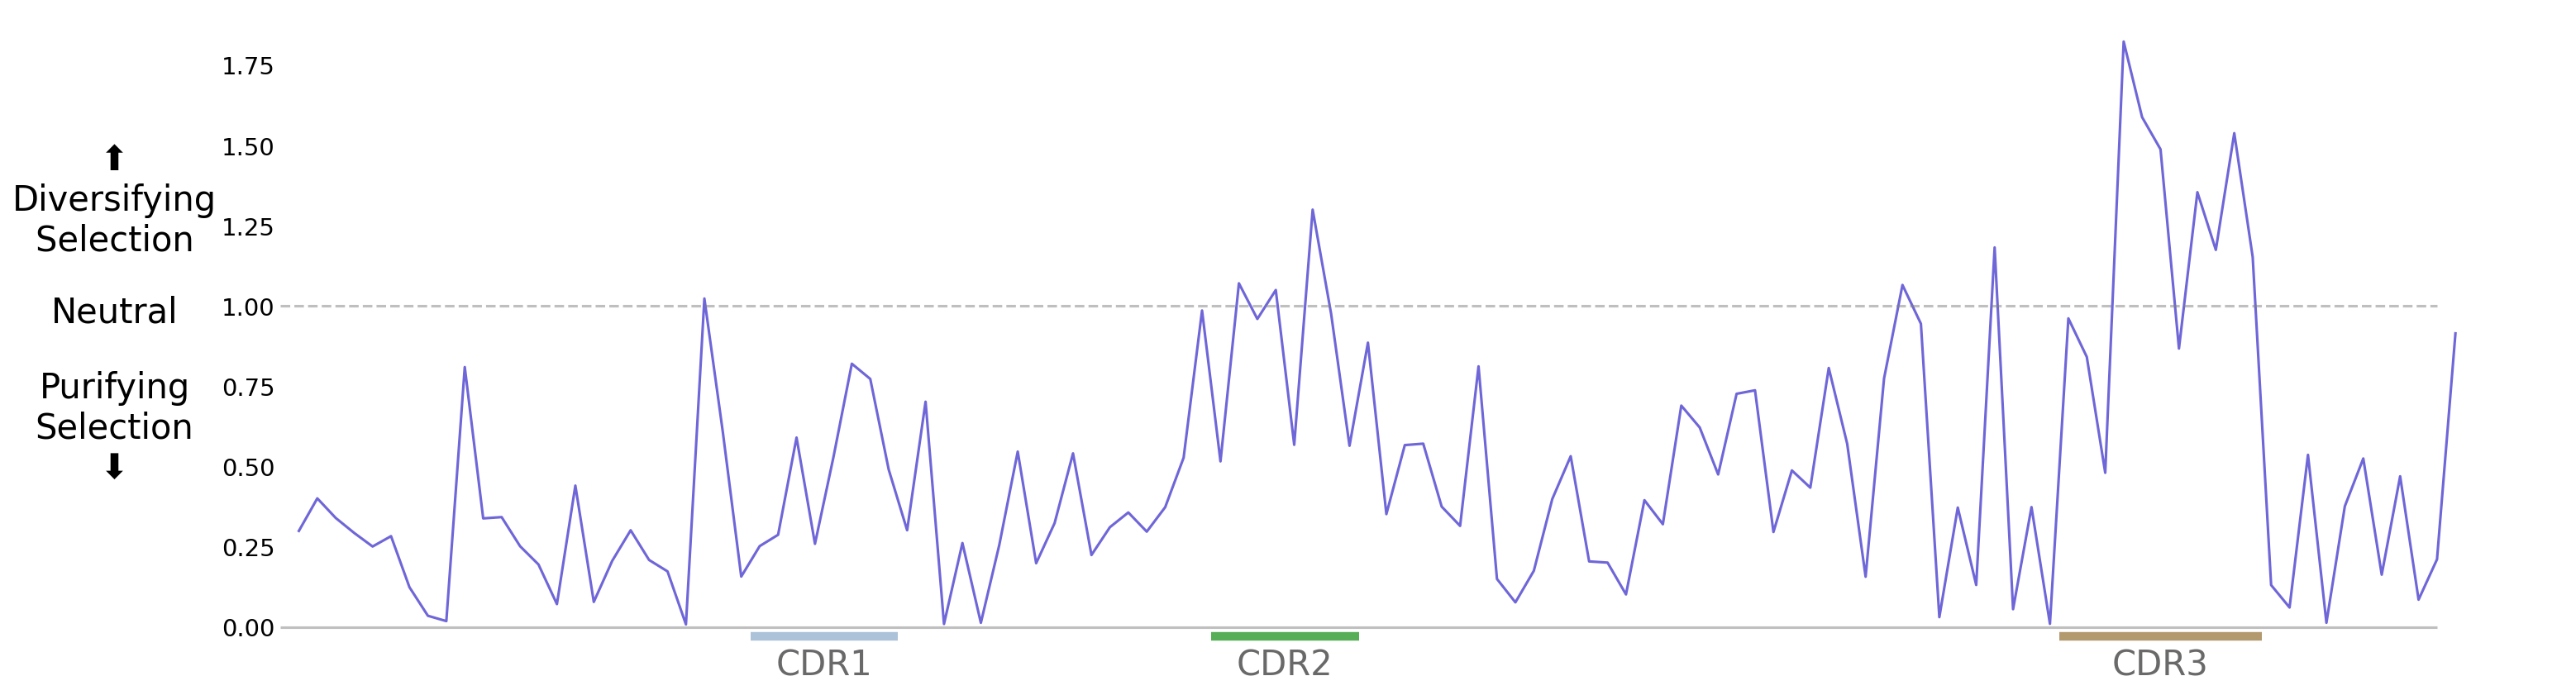

In [14]:
res_2vxs.plot_selection_factors(plot_letters=False)

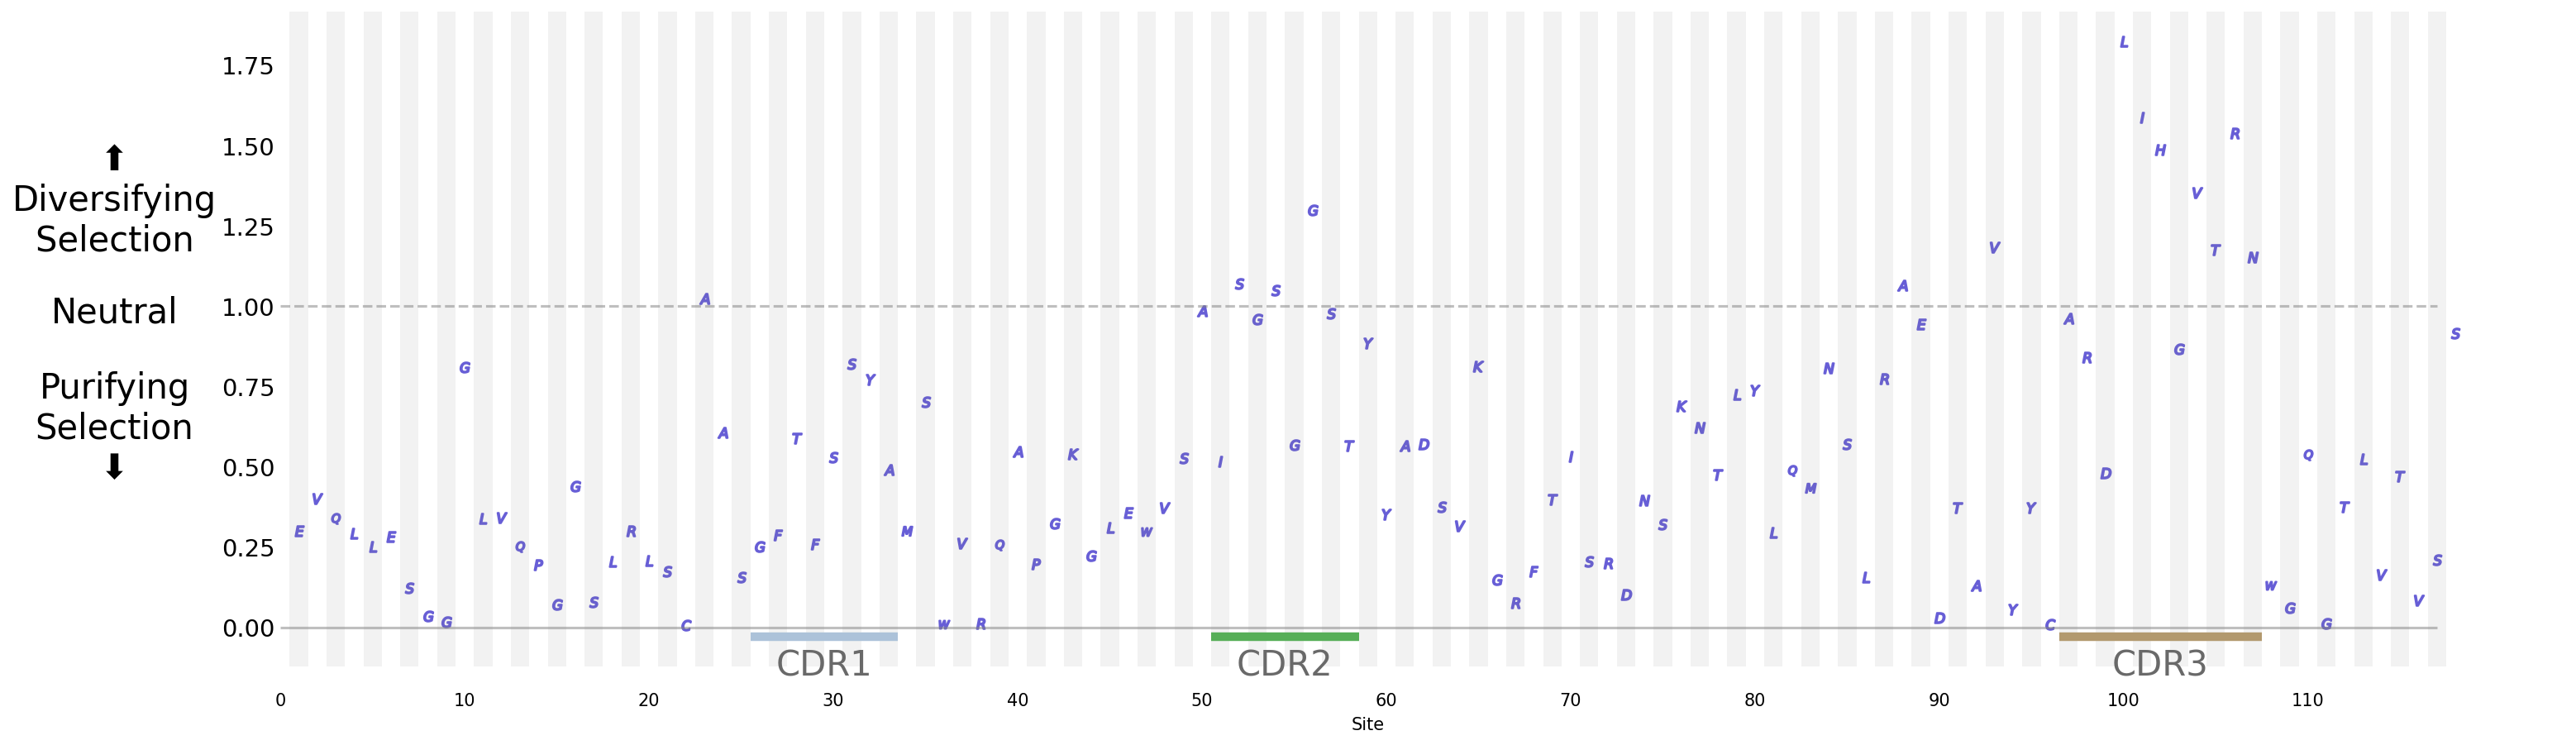

In [15]:
res_2vxs.plot_selection_factors(plot_letters=True)

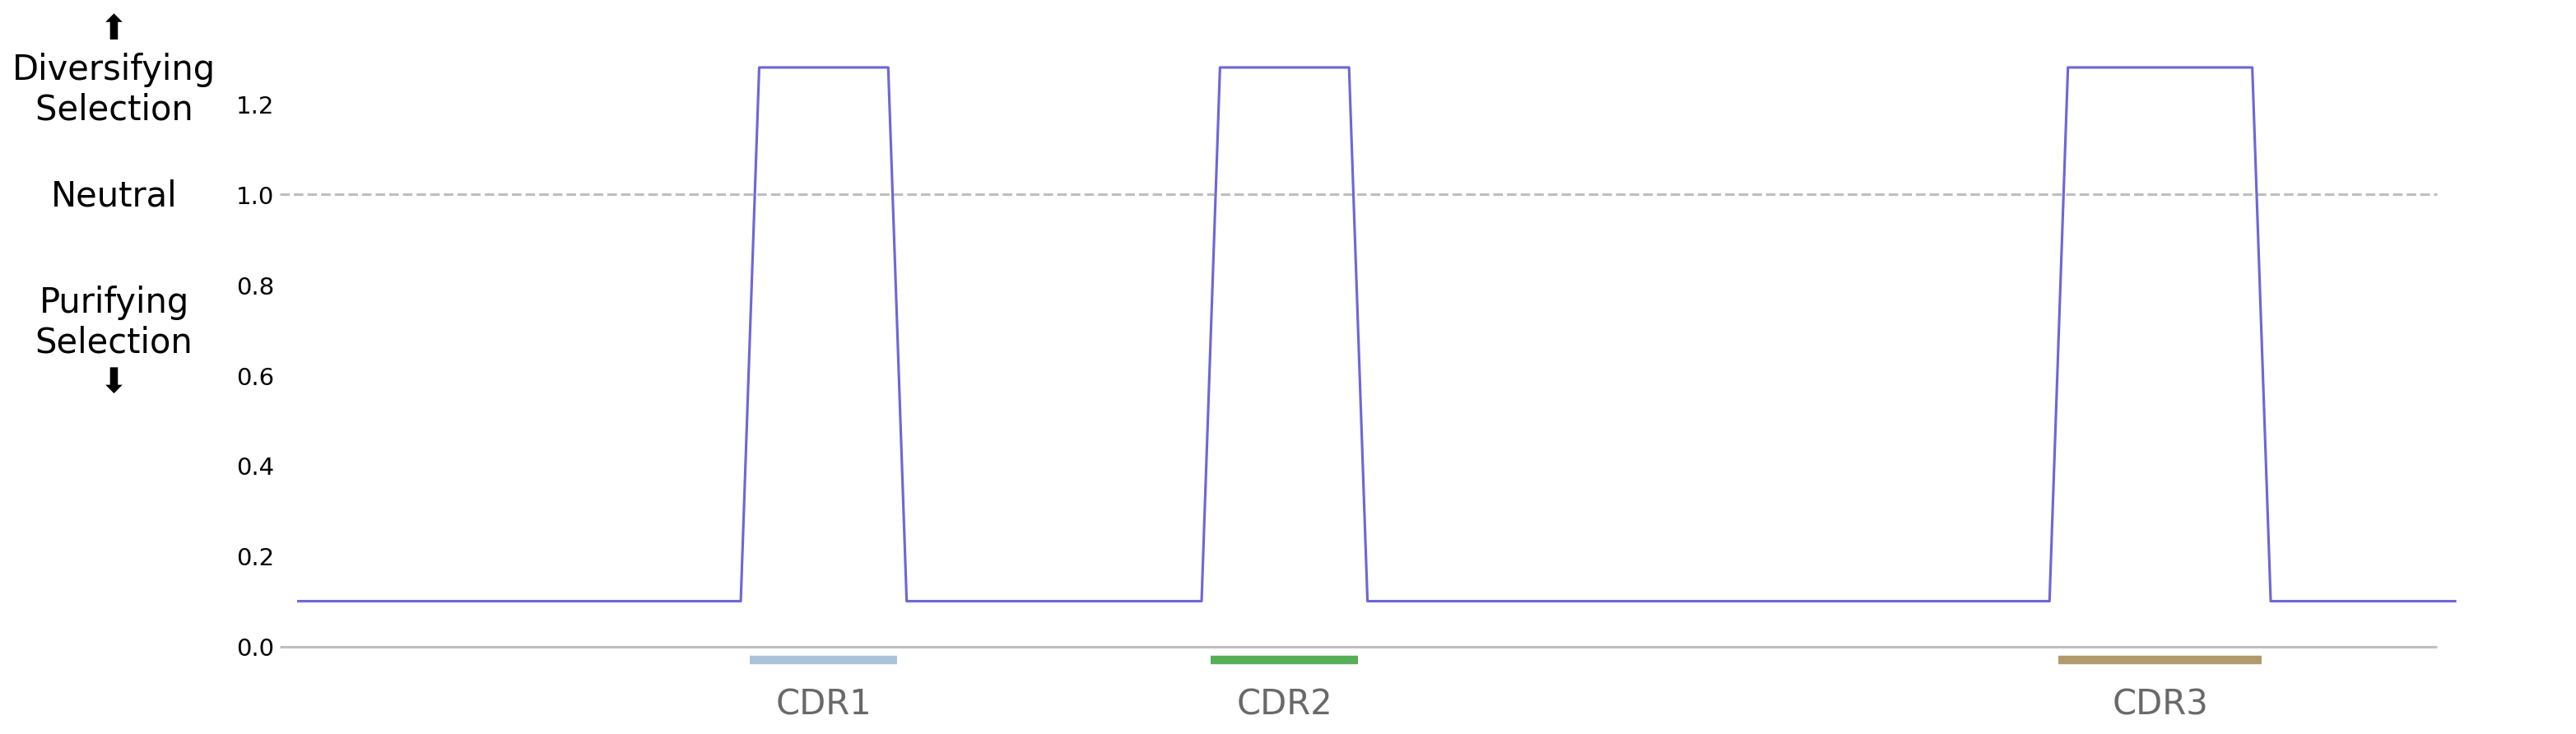

In [16]:
# Make a fake 2vxs selection factor which is 0.1 for all sites other than those in cdr_locations_2vxs, where it is 1.1
fake_2vxs_f = np.ones(len(igh_2vxs_f)) * 0.1
for start, end in cdr_locations_2vxs.values():
    fake_2vxs_f[start:end] = 1.28
    
res_fake = ResultContainer(igh_2vxs, cdr_locations_2vxs, fake_2vxs_f, 'fake_2VXS')
res_fake.plot_selection_factors(plot_letters=False)

### 6MTX

In [17]:
# https://www.rcsb.org/sequence/6MTX

igh_6mtx_with_constant = "QVQLQESGPGLVKSSETLSLSCTVSGASISNFYWSWVRQPPGKGLEWMGSIYYTGTITYNPSLKSRLTMSVDTSKNQFSLKLNSVTAADTAVYSCAGLDRFNWNDEGDCWGQGTLVTVFSASTKGPSVFPLAPSSKSTSGGTAALGCLVKDYFPEPVTVSWNSGALTSGVHTFPAVLQSSGLYSLSSVVTVPSSSLGTQTYICNVNHKPSNTKVDKKVEPKSCDK"
igh_6mtx = igh_6mtx_with_constant[:118]
igh_6mtx_f = selection_factors_func(igh_6mtx)
igh_6mtx

'QVQLQESGPGLVKSSETLSLSCTVSGASISNFYWSWVRQPPGKGLEWMGSIYYTGTITYNPSLKSRLTMSVDTSKNQFSLKLNSVTAADTAVYSCAGLDRFNWNDEGDCWGQGTLVTV'

In [18]:
# from https://www.imgt.org/IMGTrepertoire/Proteins/alleles/index.php?species=Homo%20sapiens&group=IGHV&gene=IGHV4-59   (but adjusted to use 1-indexing)
cdr_locations_6mtx = {
    'CDR1': (25, 33),
    'CDR2': (51, 58),
    'CDR3': (95, 109) 
}

cdr_regions_6mtx = {cdr: igh_6mtx[start:end] for cdr, (start, end) in cdr_locations_6mtx.items()}

cdr_regions_6mtx

{'CDR1': 'GASISNFY', 'CDR2': 'YYTGTIT', 'CDR3': 'AGLDRFNWNDEGDC'}

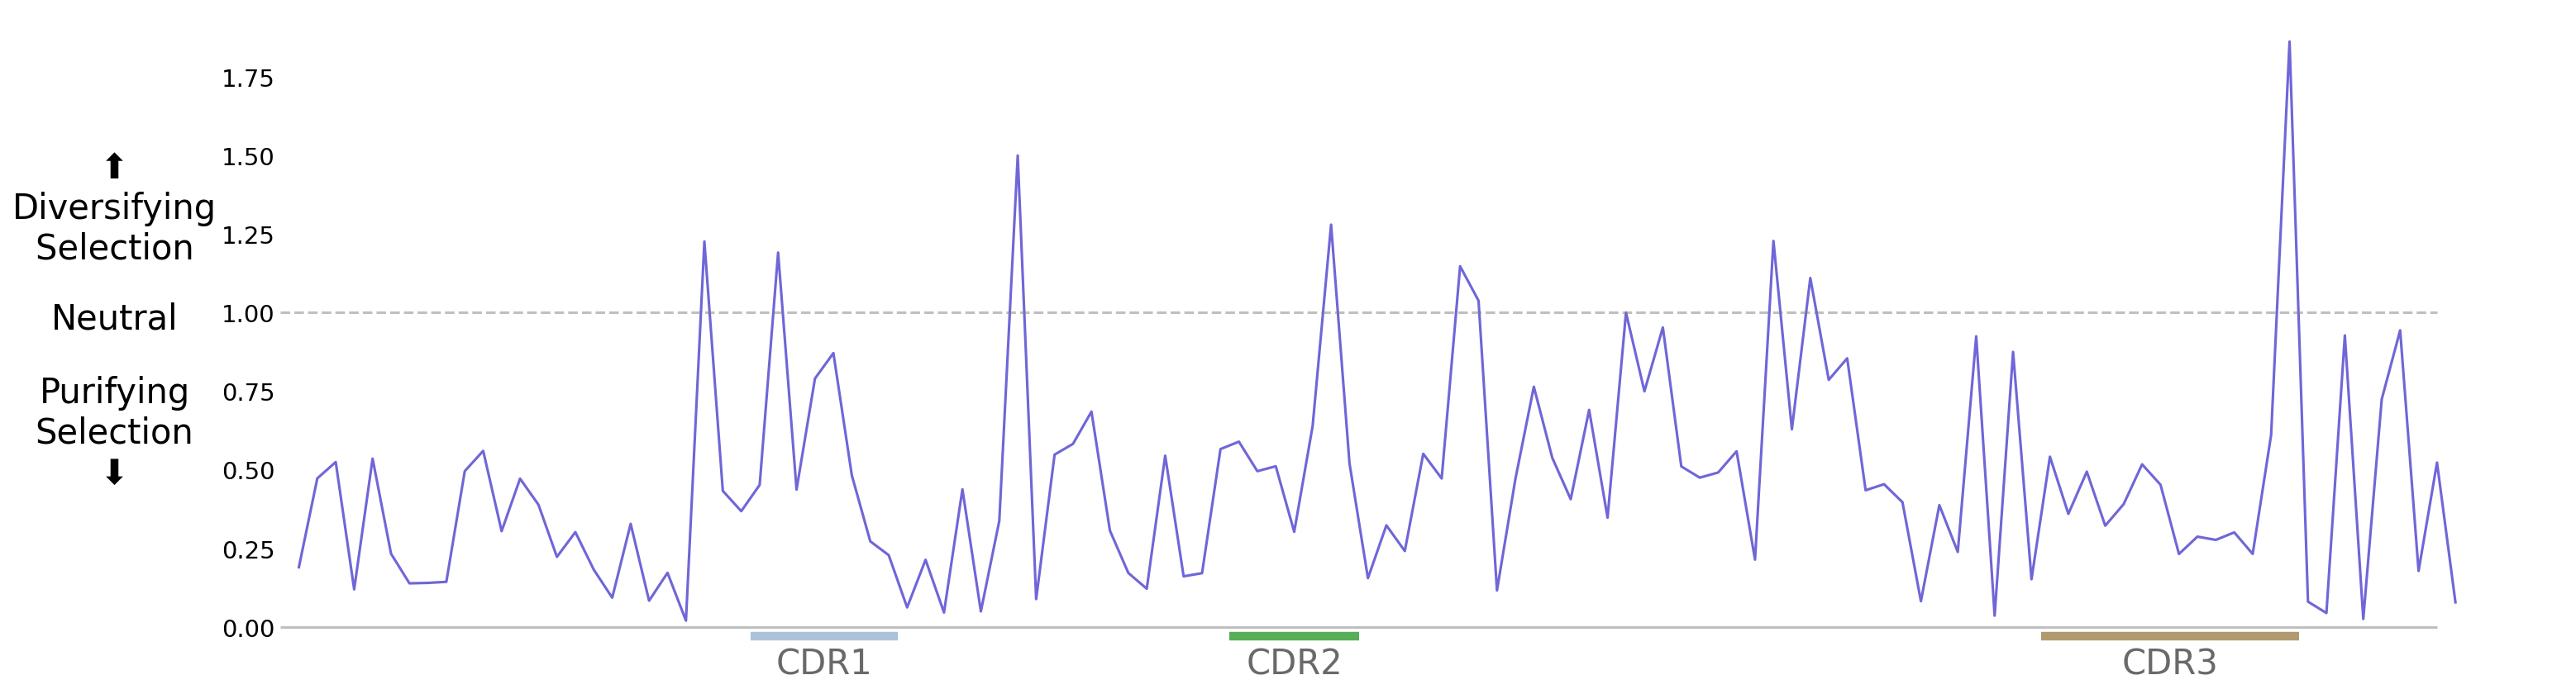

In [19]:
res_6mtx = ResultContainer(igh_6mtx, cdr_locations_6mtx, igh_6mtx_f, "6MTX")
res_6mtx.plot_selection_factors(plot_letters=False)

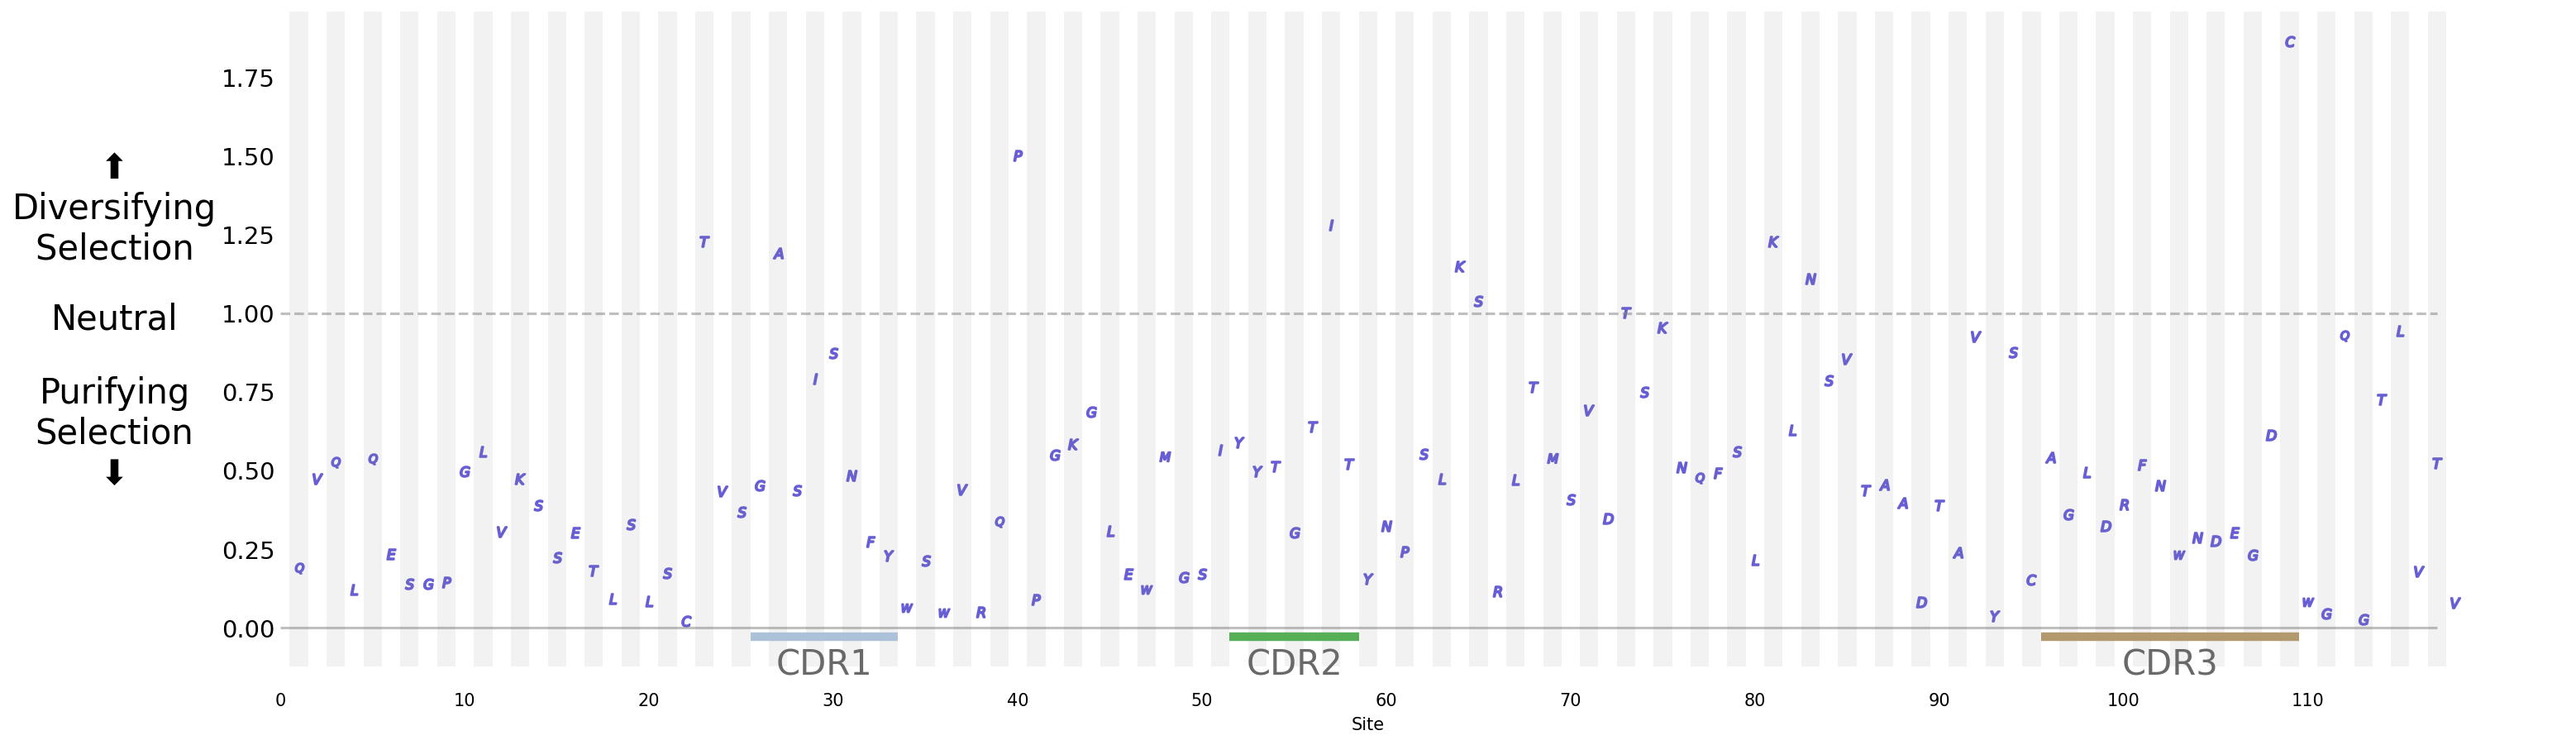

In [20]:
res_6mtx.plot_selection_factors(plot_letters=True)